In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

In [3]:
# Load datasets
train_df = pd.read_csv('training loan dataset.csv')
test_df = pd.read_csv('loan dataset.csv')

# Display the first few rows of the dataset
print(train_df.head())

# Basic info about the dataset
print(train_df.info())

# Check for missing values
print(train_df.isnull().sum())

    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             1.0   

In [4]:
# Data preprocessing
# Fill missing values
train_df['Gender'].fillna(train_df['Gender'].mode()[0], inplace=True)
train_df['Married'].fillna(train_df['Married'].mode()[0], inplace=True)
train_df['Dependents'].fillna(train_df['Dependents'].mode()[0], inplace=True)
train_df['Self_Employed'].fillna(train_df['Self_Employed'].mode()[0], inplace=True)
train_df['LoanAmount'].fillna(train_df['LoanAmount'].median(), inplace=True)
train_df['Loan_Amount_Term'].fillna(train_df['Loan_Amount_Term'].mode()[0], inplace=True)
train_df['Credit_History'].fillna(train_df['Credit_History'].mode()[0], inplace=True)

In [5]:
label_encoders = {}
for feature in ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']:
    label_encoders[feature] = LabelEncoder()
    train_df[feature] = label_encoders[feature].fit_transform(train_df[feature])


In [6]:
X = train_df.drop(columns=['Loan_ID', 'Loan_Status'])
y = train_df['Loan_Status']

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Optional: Scale numerical features
    ('clf', RandomForestClassifier(random_state=42))
])

In [9]:
param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}


In [10]:
# Grid search to find best parameters
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
best_clf = grid_search.best_estimator_

Best parameters found:  {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}


In [11]:
y_pred = best_clf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy on validation set:", accuracy)

Accuracy on validation set: 0.7642276422764228


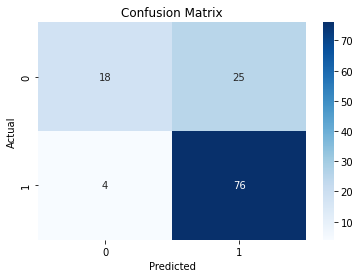

In [12]:
# Confusion matrix
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [13]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.42      0.55        43
           1       0.75      0.95      0.84        80

    accuracy                           0.76       123
   macro avg       0.79      0.68      0.70       123
weighted avg       0.78      0.76      0.74       123



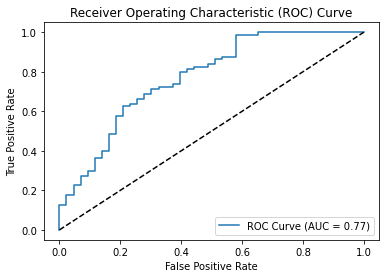

In [14]:
y_pred_proba = best_clf.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_val, y_pred_proba)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

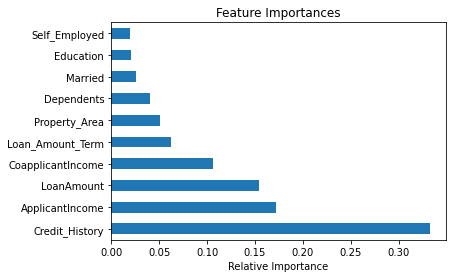

In [15]:
# Feature importances
feature_importances = pd.Series(best_clf.named_steps['clf'].feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.xlabel('Relative Importance')
plt.title('Feature Importances')
plt.show()

In [16]:
# Predict on test set for submission
test_df['Gender'].fillna(test_df['Gender'].mode()[0], inplace=True)
test_df['Dependents'].fillna(test_df['Dependents'].mode()[0], inplace=True)
test_df['Self_Employed'].fillna(test_df['Self_Employed'].mode()[0], inplace=True)
test_df['LoanAmount'].fillna(test_df['LoanAmount'].median(), inplace=True)
test_df['Loan_Amount_Term'].fillna(test_df['Loan_Amount_Term'].mode()[0], inplace=True)
test_df['Credit_History'].fillna(test_df['Credit_History'].mode()[0], inplace=True)

for feature in ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']:
    test_df[feature] = label_encoders[feature].transform(test_df[feature])

X_test = test_df.drop(columns=['Loan_ID'])


In [17]:
predictions = best_clf.predict(X_test)

In [18]:
# Prepare submission file
submission = pd.DataFrame({
    'Loan_ID': test_df['Loan_ID'],
    'Loan_Status': predictions
})

In [19]:
# Convert predictions back to original categories
submission['Loan_Status'] = submission['Loan_Status'].map({1: 'Y', 0: 'N'})

In [29]:
# Save submission to Excel
submission.to_excel('loan_prediction_results.xlsx', index=False)

print("Submission saved to Excel file: 'loan_prediction_results.xlsx'")



Submission saved to Excel file: 'loan_prediction_results.xlsx'
